In [1]:
import numpy as np
import pandas as pd
from scipy.integrate import quad, fixed_quad
from matplotlib import pyplot as plt
plt.style.use('fivethirtyeight')
from tqdm import tqdm
# plt.style.use('default')
# plt.style.use('bmh')
# plt.style.use('ggplot')
# plt.style.use('grayscale')

In [2]:
detail = 1000
T = np.linspace(0, 1, detail) # Only needed when drawing the function

In [3]:
# DONE
indicator = lambda t, l, u: 1 if ((t==u==1)|((t>=l)&(t<u))) else 0 # This complicated expression is needed to ensure no bugs in the output.
def step(t, w):
       internal_knots = len(w)-1
       increment = 1/(internal_knots+1) # w=[0, 1, -1] -> increment = 1/(2+1)=0.33 -> [0, 0.33, 0.66, 1]
       lower = [increment*i for i in range(internal_knots+1)] # [0, 0.33, 0.66]
       upper = [increment*(i+1) for i in range(internal_knots+1)] # [0.33, 0.66, 1]
       p=0
       for i in range(len(w)):
              p += indicator(t, l=lower[i], u=upper[i])*w[i]
       return p

polynomial = lambda t, p=0: t**p
def spline(t, i, p, b):
       if p==0:
              return 1 if ((t>=b[i])&(t<=b[i+1])) else 0

       first = (t-b[i]) / (b[i+p]-b[i])*spline(t=t,i=i,p=p-1,b=b)
       second = ((b[i+p+1] - t) / (b[i+p+1] - b[i+1]))*spline(t=t, i=i+1, p=p-1, b=b)
       return first + second

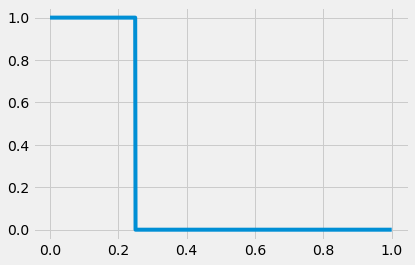

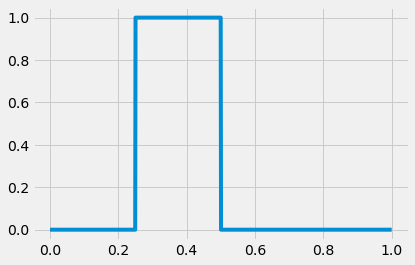

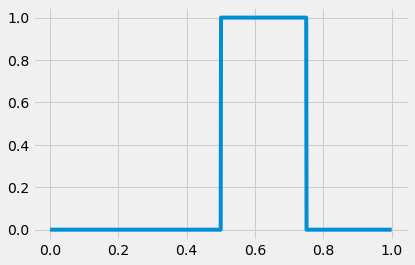

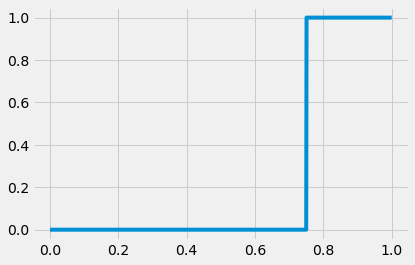

In [4]:
# DONE
breakpoints = np.linspace(0, 1, 5).tolist()
p = 0
if len(breakpoints)>10:
       print("Too many graphs to plot")
else:
       for i in range(len(breakpoints)-p-1):
              plt.plot(T, [spline(t=t, i=i, p=p, b=breakpoints) for t in T])
              plt.show()

In [5]:
# DONE
def plot_basis(ax, T, w, f):

       # fig, ax = plt.subplots()
       ax.plot(T, [f(t, w=w) for t in T], zorder=-1)

       # Calculate knots and weights
       knots = [(1/(len(w)-1+1))*(i+1) for i in range(len(w)-1+1-1)] # for easier calculations see the step function calculations
       weights = [w[i+1] for i in range(len(w)-1)] # we want to exclude the first and last points, as these will be drawn with a different colour

       # Draw knots
       ax.scatter(knots, weights , color="darkorange", s=35, zorder=1) # internal knots
       ax.scatter([0, 1], [w[0], w[len(w)-1]], color="black", s=35, zorder=1) # support knots
       # ax.set_xlabel("$t$")
       # ax.set_ylabel("$f(t)$")
       # ax.grid(visible=False)
       ax.locator_params(axis='y', nbins=3)
       ax.locator_params(axis='x', nbins=6)
       plt.ylim(-1.2,1.2)

In [6]:
def subplot_results(sub_x, sub_y, T, results, J_cb):
       fig, ax = plt.subplots(sub_x, sub_y)
       plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.3)
       # fig.tight_layout()
       row_to_plot = 0
       for i in range(sub_x):
              for j in range(sub_y):
                     plot_basis(ax=ax[i, j], T=T, w=results[row_to_plot, :].tolist(), f=step)
                     plt.ylim(-1.2,1.2)
                     row_to_plot += 1
       Z = np.concatenate((np.array([1]*(sub_x * sub_y)).reshape(-1,1), results @ J_cb), axis=1)
       opt = np.round(np.trace(np.linalg.inv(Z.T @ Z)),3)
       plt.ylim(-1.2,1.2)
       fig.suptitle(f'A-opt: {opt}')
       plt.show()
       print(f'The results plotted are: \n {results}')
       print(f'With corresponding matrix Z (= 1 | results @ J_cb):\n {Z}')
       print(f'With information matrix M (= Z.T @ Z):\n {Z.T @ Z}')
       print(f'Inverted $M^{{-1}}$:\n {np.linalg.inv(Z.T @ Z)}')
       print(f'With determinat of the inverse of the information matrix {np.linalg.det(np.linalg.inv(Z.T @ Z))}\n')
       print(f'And A-optimality criterion A (tr[$M^{{-1}}$]): {np.trace(np.linalg.inv(Z.T @ Z))}')

The `cordex` function is a function for generating a design matrix for a simulation experiment. The function takes in several arguments:

`runs`: an integer representing the number of runs of the simulation
`feats`: an integer representing the number of features or variables in the simulation
`levels`: a list of numbers representing the possible levels that the variables in the simulation can take on
`epochs`: an integer representing the number of iterations to generate the design matrix
`J_cb`: an optional parameter, a matrix of coefficients used in the calculation of the A-opt criterion

The function begins by creating a matrix of ones with the same number of rows as the number of runs, and a single column. It then enters a loop for the number of specified epochs. Within this loop, a random design matrix `Gamma` is generated with the same number of rows as runs and the same number of columns as features.

For each element in the `Gamma` matrix, the function calculates the A-opt criterion for each level in the `levels` list, and finds the minimum value of the A-opt criterion. The element in the `Gamma` matrix is then reset to the corresponding level from the `levels` list.

After all the elements in the `Gamma` matrix have been updated, the A-opt criterion is calculated using the updated matrix, and the results are appended to an array.

After all the epochs have been completed, the function finds the minimum A-opt value and returns the corresponding design matrix, as well as the minimum A-opt value.

This function uses the `gen_rand_design` function to generate a random design matrix, `np.concatenate` to concatenate the matrix of ones with the matrix of coefficients, `np.linalg.inv` to calculate the inverse of a matrix, `np.trace` to calculate the trace of a matrix, `np.array` to create an array and `tqdm` which is a library used to show the progress of a loop.

In [7]:
# DONE
gen_rand_design = lambda runs, feats: np.random.rand(runs, feats) - 0.5 # centered around 0
def cordex(runs, feats, levels, epochs, J_cb=None):
       """
       Coordinate Exchange Algorithm for A-optimality.

       Parameters:
       - runs: number of experiments to design (example runs=4)
       - feats: number of featurs of the design matrix (example feats = 18)
       - levels: a list of all possible levels that each level can take (example levels = [-1,0,1])
       - epochs: number of times to restart the algorithm in order to be more sure that we will find the total maximum (example epochs=1000)
       - J_cb: the matrix of the dot product of the fucntional basis

       Returns:
       - Design_best: Best design of the experiment
       - A_opt_best: the A-optimality criterion, associated with the best Design (Design_best)
       """
       ones = np.array([1]*runs).reshape(-1,1) # [n x 1]
       epochs_list = []
       for epoch in tqdm(range(epochs)):
              Gamma = gen_rand_design(runs=runs, feats=feats) # [n x n_x]
              for run in range(runs):
                     for feat in range(feats):
                            best_level_list = []
                            for level in levels:
                                   Gamma[run, feat] = level
                                   Zetta = np.concatenate((ones, Gamma @ J_cb), axis = 1) # [n x (n_b+1)] since J_cb = [n_x x n_b]
                                   M = Zetta.T @ Zetta # [(n_b + 1) x (n_b + 1)]
                                   try:
                                          A_opt = np.trace(np.linalg.inv(M))
                                          best_level_list.append(A_opt)
                                   except np.linalg.LinAlgError as e:
                                          best_level_list.append(np.infty)
                                          continue

                            # For each level for the (run, feat) element of the Design matrix
                            # Find the minimum value of the A-opt criterion, and reset Gamma[run, feat] to be that element on the next loop
                            best_level_index = best_level_list.index(min(best_level_list))
                            Gamma[run, feat] = levels[best_level_index]

              # For each epoch, compute the A-opt criterion to keep in an array.
              # The array is going to be used at the end of the epochs loop to find the min A-opt values.
              Zetta = np.concatenate((ones, Gamma @ J_cb), axis=1)
              M = Zetta.T @ Zetta
              try:
                     A_opt = np.trace(np.linalg.inv(M))
              except np.linalg.LinAlgError as e:
                     continue
              epochs_list.append([epoch, A_opt, Gamma])
       epochs_list = np.array(epochs_list, dtype=object)
       epochs_min_idx = epochs_list[:, 1].argmin()
       Design_best = epochs_list[epochs_min_idx, 2]
       A_opt_best = epochs_list[epochs_min_idx, 1]

       return Design_best, A_opt_best

In [8]:
def calculate_criterion(info_matrix, criterion='A'):
       if criterion=='A':
              try:
                     cr = np.trace(np.linalg.inv(info_matrix))
              except Exception as e:
                     cr = np.infty
              return cr


In [9]:
def cordex_2(runs, feats, levels, epochs, J_cb=None, criterion='A'):
       # doesn't work
       ones = np.array([1]*runs).reshape(-1,1) # [n x 1]
       Des = np.zeros((runs, feats))
       for epoch in tqdm(range(epochs)):
              opt_value = np.infty
              Gamma = gen_rand_design(runs, feats) # [n x n_x]
              for run in range(runs):
                     for feat in range(feats):
                            for level, _ in enumerate(levels):
                                   Gamma[run, feat] = level
                                   Zetta = np.concatenate((ones, Gamma), axis=1) if J_cb is None else np.concatenate((ones, Gamma @ J_cb), axis=1)
                                   M = Zetta.T @ Zetta
                                   # Don't care when det of model matrix is very small or zero
                                   # try:
                                   #        Det = np.linalg.det(M)
                                   #        print(f"DET: {Det}")
                                   #        opt_value_i = calculate_criterion(info_matrix=M, criterion=criterion)
                                   # except Exception as e:
                                   #        print("except")
                                   #        Det = 0 # Set it to zero to get rid of this iteration
                                   #        opt_value_i = np.infty
                                   # if Det < 0.0001:
                                   #        print("small det")
                                   #        opt_value_i = np.infty

                                   opt_value_i = calculate_criterion(info_matrix=M, criterion='A')
                                   if opt_value_i < opt_value:
                                          opt_value = opt_value_i
                                          Des = Gamma
                                   else:
                                          Gamma = Des
       return Des, opt_value

In [10]:
# D-optimal
def cordex_d(runs, feats, levels, epochs, J_cb=None):
       all_epochs = []
       for epoch in range(epochs):
              Gamma = gen_rand_design(runs, feats)-0.5 # center around 0
              ones = np.array([1]*Gamma.shape[0]).reshape(-1,1)
              epochs_count = 0
              D = 0.00001
              for run in range(runs):
                     for feat in range(feats):
                            best_level_list = []
                            for level, _ in enumerate(levels):
                                   Gamma[run, feat] = levels[level]
                                   # M = J_cb.T @ Gamma.T @ Gamma @ J_cb
                                   Zetta = np.concatenate((ones, Gamma), axis=1) if J_cb is None else np.concatenate((ones, Gamma @ J_cb), axis=1)
                                   # M = Gamma.T @ Gamma if J_cb is None else J_cb.T @ Gamma.T @ Gamma @ J_cb
                                   M = Zetta.T @ Zetta
                                   # criterion = np.linalg.det(M)
                                   criterion = np.linalg.det(M)
                                   best_level_list.append(criterion)
                            best_level = best_level_list.index(max(best_level_list))
                            Gamma[run, feat] = levels[best_level]
              # badly written patch that I need to fix afterwards
              Z = np.concatenate((ones, Gamma), axis=1) if J_cb is None else np.concatenate((ones, Gamma @ J_cb), axis=1)
              if np.linalg.det(Z.T @ Z) <= D:
                     epochs_count+=1
                     continue
              all_epochs.append((epoch, np.linalg.det(Z.T @ Z), Gamma))
              # -------------------------------------------------
              # all_epochs.append((epoch, 1/np.trace(np.linalg.inv(Gamma.T @ Gamma)), Gamma)) # Olo lathos
       all = np.array(all_epochs, dtype=object)
       idx = all[:, 1].argmax()
       final = all[idx, 2]
       best_criterion = all[idx, 1]
       return final, best_criterion, epochs_count

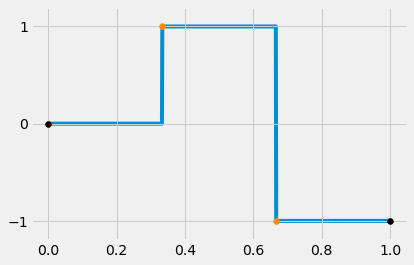

In [11]:
fig, ax = plt.subplots(1,1)
plot_basis(ax=ax, T=T, w=[0,1,-1], f=step)

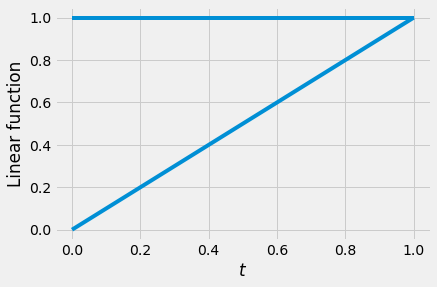

In [12]:
fig, ax = plt.subplots()

plt.plot(T, [polynomial(t, p=0) for t in T], color="C0")
plt.plot(T, [polynomial(t, p=1) for t in T], color="C0")
ax.set_xlabel("$t$")
ax.set_ylabel("Linear function")
ax.grid(visible=True)
plt.show()

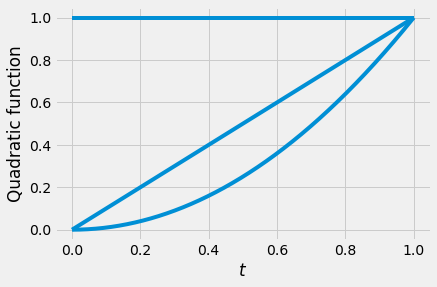

In [13]:
fig, ax = plt.subplots()

plt.plot(T, [polynomial(t, p=0) for t in T], color="C0")
plt.plot(T, [polynomial(t, p=1) for t in T], color="C0")
plt.plot(T, [polynomial(t, p=2) for t in T], color="C0")
ax.set_xlabel("$t$")
ax.set_ylabel("Quadratic function")
ax.grid(visible=True)
plt.show()

In [14]:
# quad(step, 0, 1, args=([1,1,1]))
# quad(lambda t: (step(t, w=[0,1,-1]))*(polynomial(t, p=0) + polynomial(t, p=1)), 0, 1)[0]

In [15]:
#TODO
elements = lambda n, p, l1=0: quad(lambda t: (indicator(t, l=l1/n, u=(l1+1)/n))*(polynomial(t, p=p)), l1/n, (l1+1)/n)[0]
# elements_sum = lambda n, p, l1=0: np.sum([indicator(t, l=l1/n, u=(l1+1)/n)*polynomial(t, p=p) for t in np.linspace(0, 1, 10000)])/10000
calc_basis_matrix = lambda x_basis, b_basis: np.array([[elements(n=x_basis, p=p, l1=l1) for p in range(b_basis)] for l1 in range(x_basis)])

# elements2 = lambda n, p, x_basis, b_basis, l1=0: quad(lambda t: (indicator(t, l=l1/n, u=(l1+1)/n))*(polynomial(t, p=p)), 0, 1)[0]
# calc_basis_matrix2 = lambda x_basis, nx, b_basis, nb: np.array([[elements2(n=16, p=p, l1=l1, x_basis, b_basis) for p in range(nb)] for l1 in range(nx)])


In [16]:
def multiplication_test(t):
       return indicator(t, l=2/100, u=3/100)*polynomial(t, p=1)

In [17]:
quad(multiplication_test, 2/100, 3/100)

(0.00025, 2.7755575615628915e-18)

In [18]:
J_cb= calc_basis_matrix(x_basis=100, b_basis=2)
J_cb

array([[1.00e-02, 5.00e-05],
       [1.00e-02, 1.50e-04],
       [1.00e-02, 2.50e-04],
       [1.00e-02, 3.50e-04],
       [1.00e-02, 4.50e-04],
       [1.00e-02, 5.50e-04],
       [1.00e-02, 6.50e-04],
       [1.00e-02, 7.50e-04],
       [1.00e-02, 8.50e-04],
       [1.00e-02, 9.50e-04],
       [1.00e-02, 1.05e-03],
       [1.00e-02, 1.15e-03],
       [1.00e-02, 1.25e-03],
       [1.00e-02, 1.35e-03],
       [1.00e-02, 1.45e-03],
       [1.00e-02, 1.55e-03],
       [1.00e-02, 1.65e-03],
       [1.00e-02, 1.75e-03],
       [1.00e-02, 1.85e-03],
       [1.00e-02, 1.95e-03],
       [1.00e-02, 2.05e-03],
       [1.00e-02, 2.15e-03],
       [1.00e-02, 2.25e-03],
       [1.00e-02, 2.35e-03],
       [1.00e-02, 2.45e-03],
       [1.00e-02, 2.55e-03],
       [1.00e-02, 2.65e-03],
       [1.00e-02, 2.75e-03],
       [1.00e-02, 2.85e-03],
       [1.00e-02, 2.95e-03],
       [1.00e-02, 3.05e-03],
       [1.00e-02, 3.15e-03],
       [1.00e-02, 3.25e-03],
       [1.00e-02, 3.35e-03],
       [1.00e-

In [19]:
target = [[8.750, 3.958, 2.583],
          [8.828, 4.287, 2.778],
          [8.750, 3.903, 2.570],
          [8.493, 3.902, 2.539],
          [8.427, 3.887, 2.520],
          [8.404, 3.882, 2.512]]

In [21]:
N_X = np.array([2, 3, 4, 8, 16, 100])
N = np.array([4, 8, 12])
best_cr_mat = np.zeros((len(N_X), len(N)))
i=0
for n_x in N_X:
       j = 0
       for n in N:
              J_cb = calc_basis_matrix(x_basis=n_x, b_basis=2)
              runs = n
              result, best_cr = cordex(runs=runs, feats=J_cb.shape[0], levels=np.linspace(-1,1,3).tolist(), epochs=10000, J_cb=J_cb)
              best_cr_mat[i, j] = best_cr
              j += 1
       i += 1

our_results = np.round(best_cr_mat,3)

100%|██████████| 10000/10000 [09:36<00:00, 17.36it/s]


In [ ]:
our_results.tolist()

In [ ]:
final_difs = []
for i in range(6):
       row_difs = []
       for j in range(3):
              diff = round(round(our_results[i][j],3) - round(target[i][j],3),2)
              row_difs.append(diff)
       final_difs.append(row_difs)

final_difs

In [ ]:
row_axis = ["n_x=2","n_x=3","n_x=4","n_x=8","n_x=16","n_x=100"]
pd.DataFrame(final_difs, columns=["n=4", "n=8", "n=12"], index=row_axis)

In [ ]:
J_cb = calc_basis_matrix(x_basis=8, b_basis=2)
runs = 4
feats = J_cb.shape[0]
levels = [-1,0,1]
epochs = 1000

In [ ]:
result, best_cr = cordex (runs=4, feats=J_cb.shape[0], levels=np.linspace(-1,1,3).tolist(), epochs=1000, J_cb=J_cb)

In [ ]:
best_cr

In [ ]:
Z = np.concatenate((np.array([1]*4).reshape(-1,1), result @ J_cb), axis=1)
np.trace(np.linalg.inv(Z.T @ Z))

In [ ]:
columns = 2
subplot_results(sub_x=int(4/columns), sub_y=int(columns), T=T, results=result, J_cb=J_cb)

In [ ]:
fig, ax = plt.subplots(2, 2)
# plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.3)
fig.tight_layout()
plot_basis(ax=ax[0,0], T=T, w=result[0, :].tolist(), f=step)
plot_basis(ax=ax[0,1], T=T, w=result[1, :].tolist(), f=step)
plot_basis(ax=ax[1,0], T=T, w=result[2, :].tolist(), f=step)
plot_basis(ax=ax[1,1], T=T, w=result[3, :].tolist(), f=step)
plt.show()